# Comparing global XXL-100-GC $T_{\rm{X}}$ and $L_{\rm{X}}$ measurements to literature

This notebook measures global temperatures and luminosities for the samples we are using to verify our method, then compares them to the measurements from literature. While the focus of this work is the measurement of galaxy cluster masses, temperatures and luminosities play an important role in the construction of X-ray mass-observable scaling relations - thus they must also be shown to be consistent with previous work. 

## Import Statements

In [1]:
import pandas as pd
import numpy as np
from astropy.units import Quantity, UnitConversionError
from astropy.cosmology import LambdaCDM, WMAP9
import matplotlib.pyplot as plt
from typing import Union, List
from shutil import rmtree
import os

# This adds the directory above to the path, allowing me to import the common functions that I've written in
#  common.py - this just saves me repeating boring code and makes sure its all consistent
import sys
sys.path.insert(0, '..')
from common import xxlgc100_colour, xxl_cosmo, direct_comparison_plot, find_lims, fit_comp

import xga
# This just sets the number of cores this analysis is allowed to use
xga.NUM_CORES = 60
# This is a bodge that will only work because xga_output in notebooks has already been defined, XGA
#  will be made to handle this more gracefully at some point
temp_dir = xga.OUTPUT
actual_dir = temp_dir.split('notebooks/')[0]+'notebooks/xga_output/'
xga.OUTPUT = actual_dir
xga.utils.OUTPUT = actual_dir
# As currently XGA will setup an xga_output directory in our current directory, I remove it to keep it all clean
if os.path.exists('xga_output'):
    rmtree('xga_output')
from xga.samples import ClusterSample
from xga.sources import GalaxyCluster
from xga.sources import BaseSource
from xga.xspec import single_temp_apec

## Reading in Sample Files and Declaring XGA ClusterSamples

$\color{red}{\text{NEED TO MENTION/PUBLISH THE OBSIDS THAT WE EXCLUDE FROM USE DUE TO DATA PROBLEMS LIKE FLARING}}$

This subsection involves reading in the sample files of the four test samples (described in [the sample properties notebook](sample_properties.ipynb)), then setting up separate XGA ClusterSample instances (see [the documentation](https://xga.readthedocs.io/en/latest/notebooks/tutorials/sources_samples.html) for an introduction to XGA source and sample objects.

We impose an additional cleaning step on each sample, where we make sure that (for each XMM observation initially associated with a source) at least 70% of a cluster's $R_{500}$ falls on that observation - if this requirement is not met then the observation is excluded. These requirements are set with the `clean_obs=True`, `clean_obs_reg='r500'`, and `clean_obs_threshold=0.7` arguments when a ClusterSample instance is declared.

### XXL-100-GC

This is the sample of the brightest clusters in the XXL survey. It contains temperature and luminosity measurements, and will be a useful external comparison for XGA results, though the shallow XXL data may prove a challenge.

In [2]:
xxlgc100 = pd.read_csv("../../sample_files/xxl_gc100.csv")

# Limit the comparison to clusters with a flag of 0 - meaning it is in the main sample of 100 clusters
xxlgc100 = xxlgc100[xxlgc100['Flag'] == 0]

# Excluding a specific cluster which was excluded in the XXL analysis
xxlgc100 = xxlgc100[xxlgc100['XLSSC'] != 504]

In [3]:
# Reading out the relevant values into arrays just for ease of passing into the ClusterSample object
ra = xxlgc100['ra'].values
dec = xxlgc100['dec'].values
z = xxlgc100['z'].values
n = xxlgc100['name'].values
r500 = Quantity(xxlgc100['r500MT'].values, 'Mpc')

# Declaring the actual ClusterSample instance for the XXL sample
# This is the only sample whose original analysis used the WMAP9 cosmology
xxl_srcs = ClusterSample(ra, dec, z, n, r500=r500, cosmology=xxl_cosmo, load_fits=False, use_peak=False, 
                         clean_obs=True, clean_obs_reg='r500', clean_obs_threshold=0.7, back_inn_rad_factor=3.33, 
                         back_out_rad_factor=5)
xxl_srcs['XLSSC-11'].disassociate_obs('0780452601')

Setting up Galaxy Clusters:   0%|                                                      | 0/99 [00:00<?, ?it/s]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-94 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:   1%|▍                                             | 1/99 [00:04<07:50,  4.80s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-96 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:   2%|▉                                             | 2/99 [00:12<10:11,  6.30s/it]/mnt/pact/dt23

Setting up Galaxy Clusters:  17%|███████▋                                     | 17/99 [01:18<05:15,  3.84s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-98 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  18%|████████▏                                    | 18/99 [01:21<04:54,  3.64s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-99 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  19%|████████▋                                    | 19/99 [01:25<04:47,  3.60s/it]/mnt/pact/dt23

Setting up Galaxy Clusters:  32%|██████████████▌                              | 32/99 [03:38<13:04, 11.71s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:109: UserWarning: There are 1 alternative matches for observation 0404965201, associated with source XLSSC-54
  warnings.warn("There are {0} alternative matches for observation {1}, associated with "
Setting up Galaxy Clusters:  33%|███████████████                              | 33/99 [03:43<10:42,  9.73s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:109: UserWarning: There are 1 alternative matches for observation 0780452501, associated with source XLSSC-25
  warnings.warn("There are {0} alternative matches for observation {1}, associated with "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:109: UserWarning: There are 1 alternative matches for observation 0109520401, associated with source XLSSC-25
  warnings.warn("There are {0} alternative matches for observation {1}, associ

Setting up Galaxy Clusters:  45%|████████████████████▍                        | 45/99 [06:38<11:24, 12.69s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-89 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  46%|████████████████████▉                        | 46/99 [06:46<09:56, 11.26s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/extended.py:221: UserWarning: A point source has been detected in 0677600133 and is very close to the user supplied coordinates of XLSSC-104. It will not be excluded from analysis due to the possibility of a mis-identified cool core
  warnings.warn("A point source has been detected in {o} and is very close to the user supplied "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124:

Setting up Galaxy Clusters:  62%|███████████████████████████▋                 | 61/99 [07:47<01:30,  2.38s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-518 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  63%|████████████████████████████▏                | 62/99 [07:48<01:15,  2.05s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:109: UserWarning: There are 1 alternative matches for observation 0604873944, associated with source XLSSC-531
  warnings.warn("There are {0} alternative matches for observation {1}, associated with "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-531 has not been detected in all region files, so generating and fitting products with the 'region

Setting up Galaxy Clusters:  77%|██████████████████████████████████▌          | 76/99 [08:32<01:13,  3.18s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-505 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  78%|███████████████████████████████████          | 77/99 [08:34<01:00,  2.75s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:109: UserWarning: There are 1 alternative matches for observation 0677720134, associated with source XLSSC-506
  warnings.warn("There are {0} alternative matches for observation {1}, associated with "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-506 has not been detected in all region files, so generating and fitting products with the 'region

Setting up Galaxy Clusters:  92%|█████████████████████████████████████████▎   | 91/99 [09:16<00:27,  3.39s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:109: UserWarning: There are 1 alternative matches for observation 0677761132, associated with source XLSSC-543
  warnings.warn("There are {0} alternative matches for observation {1}, associated with "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-543 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  93%|█████████████████████████████████████████▊   | 92/99 [09:22<00:28,  4.09s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-541 has not been detected in all region files, so generating and fitting products with the 'region

In [4]:
xxl_srcs.failed_reasons

{'XLSSC-61': 'Failed ObsClean', 'XLSSC-527': 'Failed ObsClean'}

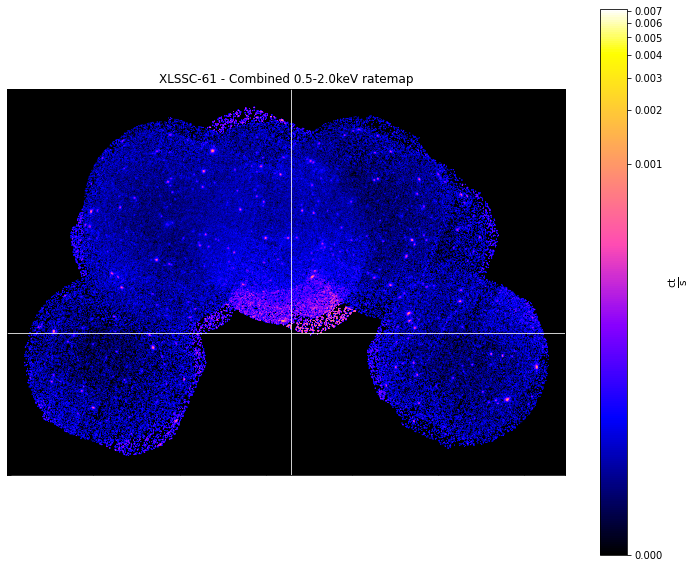

In [5]:
rel_row = xxlgc100[xxlgc100['name'] == 'XLSSC-61'].iloc[0]
xlssc61 = GalaxyCluster(rel_row['ra'], rel_row['dec'], rel_row['z'], rel_row['name'], 
                        r500=Quantity(rel_row['r500MT'], 'Mpc'), cosmology=xxl_cosmo, load_fits=True, use_peak=False, 
                       clean_obs=False, back_inn_rad_factor=3.33, back_out_rad_factor=5)
xlssc61.get_combined_ratemaps().view(xlssc61.ra_dec)

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:109: UserWarning: There are 1 alternative matches for observation 0677800137, associated with source XLSSC-527
  warnings.warn("There are {0} alternative matches for observation {1}, associated with "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-527 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"


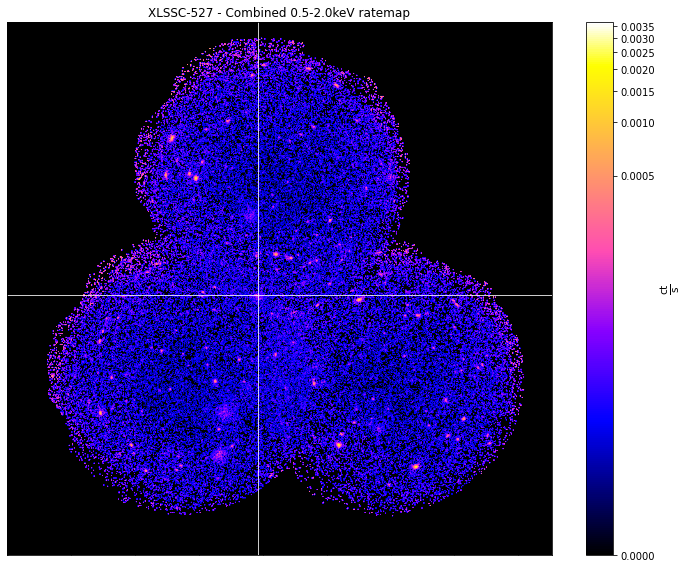

In [6]:
rel_row = xxlgc100[xxlgc100['name'] == 'XLSSC-527'].iloc[0]
xlssc527 = GalaxyCluster(rel_row['ra'], rel_row['dec'], rel_row['z'], rel_row['name'], 
                         r500=Quantity(rel_row['r500MT'], 'Mpc'), cosmology=xxl_cosmo, load_fits=True, 
                         use_peak=False, clean_obs=False, back_inn_rad_factor=3.33, back_out_rad_factor=5)
xlssc527.get_combined_ratemaps().view(xlssc527.ra_dec)

## Running $T_{\rm{X}}$ and $L_{\rm{X}}$ Measurements

The XGA XSPEC functions that we use here all automatically call the XGA SAS interface, so the necessary spectra are generated before the fits begin. As the different samples measure properties within different spatial regions, all the function calls differ slightly.

The results of the fits are stored within the indivual source objects that make up each sample.

### XXL-100-GC

The XXL temperatures and soft-band $L_{\rm{X}}$ are measured within 300 kpc, which we replicate by setting the outer radius to an astropy quantity of 300 kpc.

In [7]:
single_temp_apec(xxl_srcs, Quantity(300, 'kpc'), lo_en=Quantity(0.4, 'keV'), hi_en=Quantity(7.0, 'keV'))

Running XSPEC Fits: 100%|█████████████████████████████████████████████████████| 97/97 [00:06<00:00, 14.22it/s]


## Retrieving $T_{\rm{X}}$ and $L_{\rm{X}}$ measurements from the samples

We must extract and judge the quality of the temperature and luminosity measurements that we have made for each of the samples, then later on we will be able to directly compare them. At the same time we make sure that the results from literature are formatted in such a way that we can easily compare them.

### XXL-100-GC

In [8]:
xxl_tx_all = xxl_srcs.Tx(Quantity(300, 'kpc'), quality_checks=False)
xxl_tx = xxl_srcs.Tx(Quantity(300, 'kpc'), quality_checks=True)

xxl_lx_all = xxl_srcs.Lx(Quantity(300, 'kpc'), quality_checks=False, lo_en=Quantity(0.5, 'keV'), 
                             hi_en=Quantity(2.0, 'keV'))
xxl_lx = xxl_srcs.Lx(Quantity(300, 'kpc'), quality_checks=True, lo_en=Quantity(0.5, 'keV'), 
                         hi_en=Quantity(2.0, 'keV'))

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/extended.py:479: UserWarning: There are no XSPEC fits associated with XLSSC-11
  warn(str(err))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/base.py:280: UserWarning: There are no XSPEC fits associated with XLSSC-11
  warn(str(err))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/base.py:280: UserWarning: XLSSC-54 luminosity measurement's uncertainty greater than value.
  warn(str(err))


In [9]:
xxlgc100_tx = []
xxlgc100_lx52 = []
for n in xxl_srcs.names:
    # TODO REMOVE THE IF STATEMENT IT WON'T BE NECESSARY NEXT RUN
    if n != "XLSSC-504":
        rel_row = xxlgc100[xxlgc100['name'] == n].iloc[0]
        xxlgc100_tx.append(Quantity(rel_row[['T300kpc', 'T300kpc-', 'T300kpc+']], 'keV'))
        xxlgc100_lx52.append(Quantity(rel_row[['L52_300kpc', 'L52_300kpc_err']]*1e+43, 'erg/s'))
    else:
        xxlgc100_tx.append(Quantity([np.nan, np.nan, np.nan], 'keV'))
        xxlgc100_lx52.append(Quantity([np.nan, np.nan], 'erg/s'))
    
xxlgc100_tx = Quantity(xxlgc100_tx)
xxlgc100_lx52 = Quantity(xxlgc100_lx52)

## Direct comparisons between original and XGA measurements

This is the the point of this notebook, making direct comparisons of like for like (or as near as we can achieve) measurements from literature to measurements made using XGA. In each case we plot simple one-to-one comparisons, with a one-to-one dashed line in red to give a reference.

### XXL-100-GC

We directly compare temperatures measured within 300 kpc and luminosities (soft band and bolimetric) between the XCS3P pipeline and XGA.

In [10]:
print('{s} out of {t} XGA Tx measurements were successful'.format(s=np.isfinite(xxl_tx[:, 0]).sum(), 
                                                                  t=len(xxl_tx)))
print('{s} out of {t} XGA Lx52 measurements were successful'.format(s=np.isfinite(xxl_lx[:, 0]).sum(), 
                                                                    t=len(xxl_lx)))

96 out of 97 XGA Tx measurements were successful
95 out of 97 XGA Lx52 measurements were successful


#### $T_{\rm{X}, 300kpc}$ and $L^{\rm{0.5-2.0}}_{\rm{X}, 300kpc}$

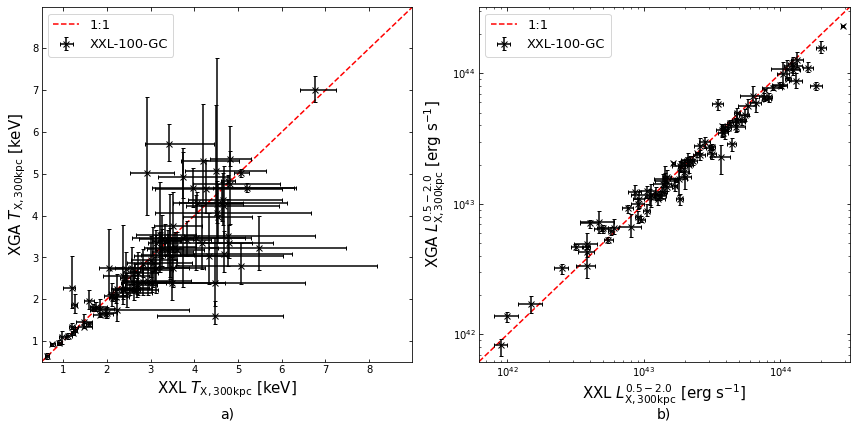

In [12]:
direct_comparison_plot([xxlgc100_tx, xxlgc100_lx52], [xxl_tx, xxl_lx], 
                       [r"XXL $T_{\rm{X, 300kpc}}$ [keV]", 
                        r"XXL $L^{\rm{0.5-2.0}}_{\rm{X, 300kpc}}$ [erg s$^{-1}$]"], 
                       [r"XGA $T_{\rm{X, 300kpc}}$ [keV]", 
                        r"XGA $L^{\rm{0.5-2.0}}_{\rm{X, 300kpc}}$ [erg s$^{-1}$]"],
                       r"XXL-100-GC", (12, 6), ['linear', 'log'], ['linear', 'log'], 
                       savepath='../../outputs/figures/xxl_Tx_Lx52_comp.pdf')

  0%|                                                                               | 0/20000 [00:00<?, ?it/s]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/emcee-3.1.1-py3.8.egg/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|█████████████████████████████████████████████████████████████████| 20000/20000 [00:18<00:00, 1108.63it/s]


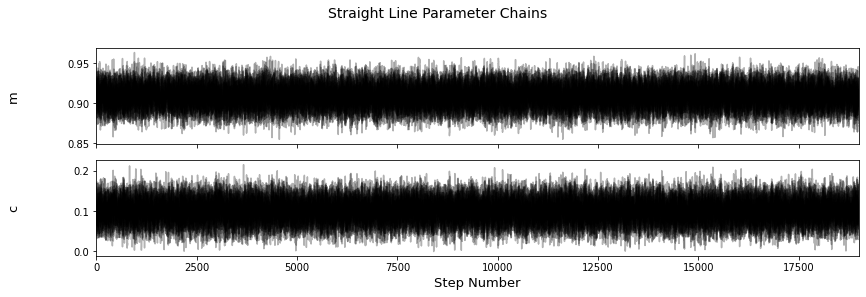

Removed no burn in


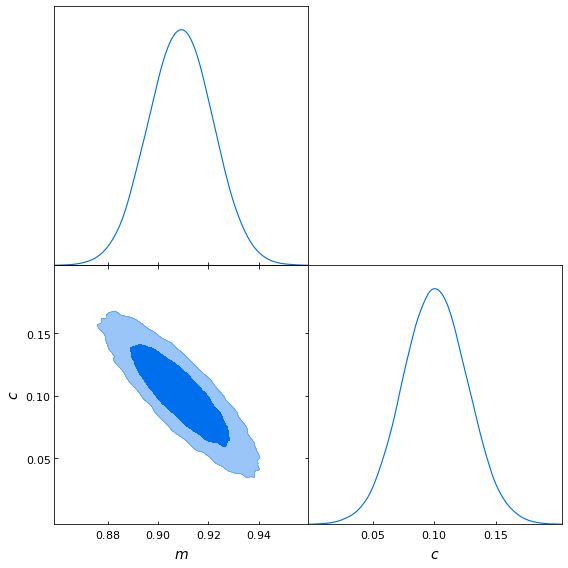

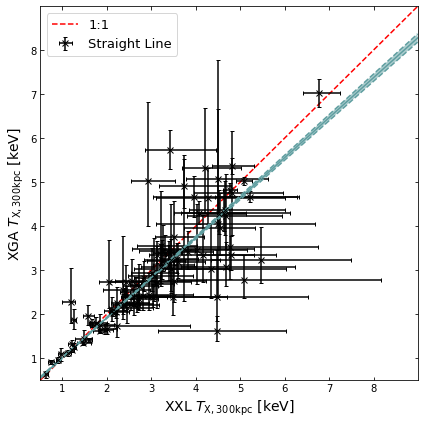

m=0.909 +0.013 -0.013 [1sig]
c=0.101 +0.027 -0.026 [1sig]


In [13]:
fit_comp(xxlgc100_tx, xxl_tx, [[0, 100], [0, 5]], r"XXL $T_{\rm{X, 300kpc}}$ [keV]", 
         r"XGA $T_{\rm{X, 300kpc}}$ [keV]", Quantity(1, 'keV'),  num_steps=20000, view_chains=True, 
         linear=True, view_corner=True)

100%|██████████████████████████████████████████████████████████████████| 20000/20000 [00:20<00:00, 982.02it/s]


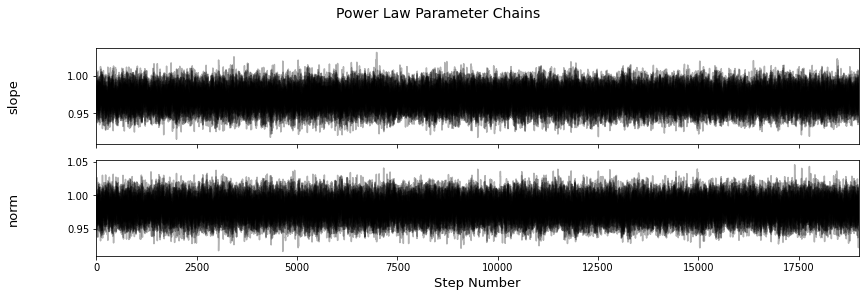

Removed no burn in


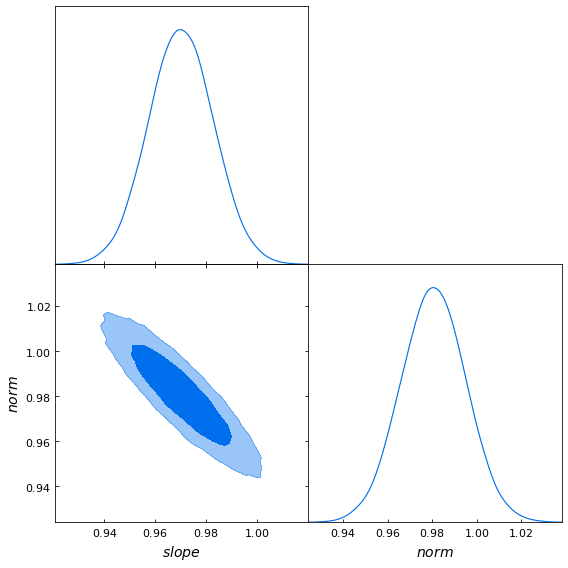

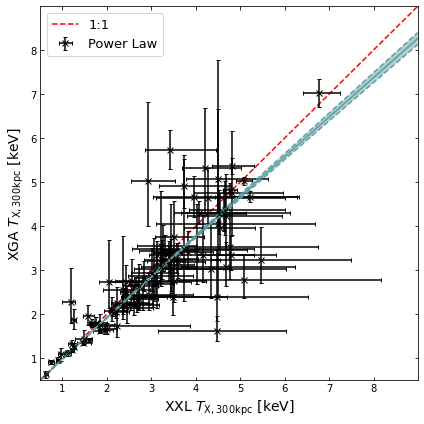

slope=0.97 +0.013 -0.013 [1sig]
norm=0.981 +0.015 -0.015 [1sig]


In [16]:
fit_comp(xxlgc100_tx, xxl_tx, [[0, 100], [0, 5]], r"XXL $T_{\rm{X, 300kpc}}$ [keV]", 
         r"XGA $T_{\rm{X, 300kpc}}$ [keV]", Quantity(1, 'keV'),  num_steps=20000, view_chains=True, 
         linear=False, view_corner=True)

100%|██████████████████████████████████████████████████████████████████| 20000/20000 [00:20<00:00, 989.05it/s]


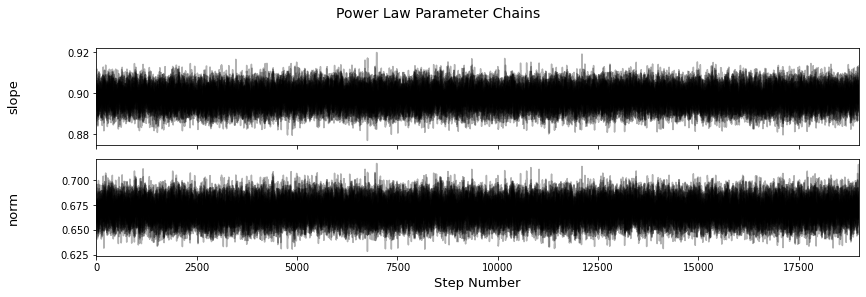

Removed no burn in


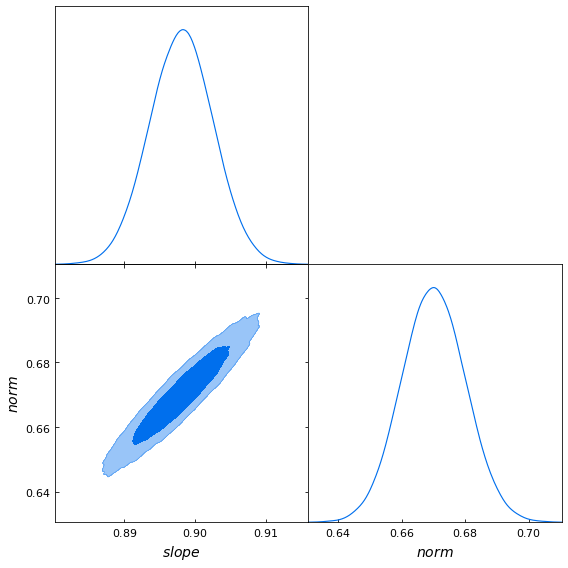

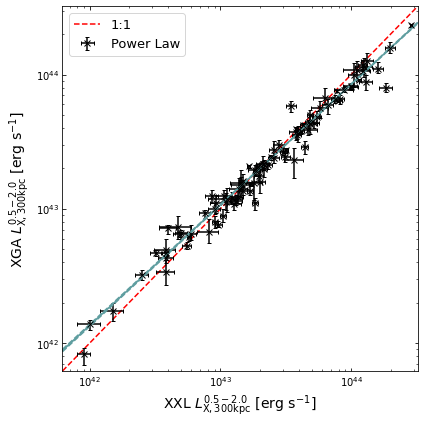

slope=0.898 +0.005 -0.005 [1sig]
norm=0.67 +0.01 -0.01 [1sig]


In [14]:
fit_comp(xxlgc100_lx52, xxl_lx, [[0, 100], [0, 5]], r"XXL $L^{\rm{0.5-2.0}}_{\rm{X, 300kpc}}$ [erg s$^{-1}$]", 
         r"XGA $L^{\rm{0.5-2.0}}_{\rm{X, 300kpc}}$ [erg s$^{-1}$]", Quantity(1e+45, 'erg/s'), num_steps=20000, 
         view_chains=True, linear=False, view_corner=True, xscale='log', yscale='log')

100%|█████████████████████████████████████████████████████████████████| 20000/20000 [00:18<00:00, 1088.58it/s]


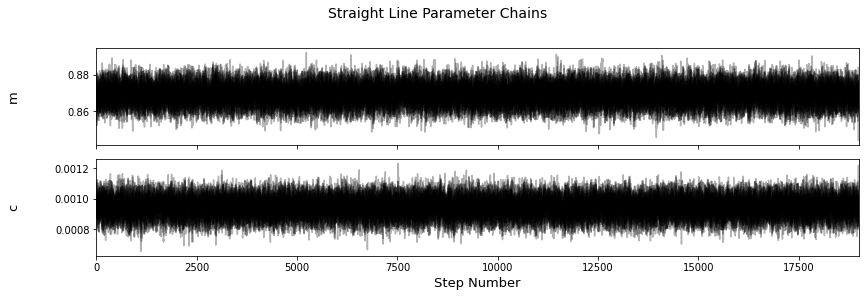

Removed no burn in


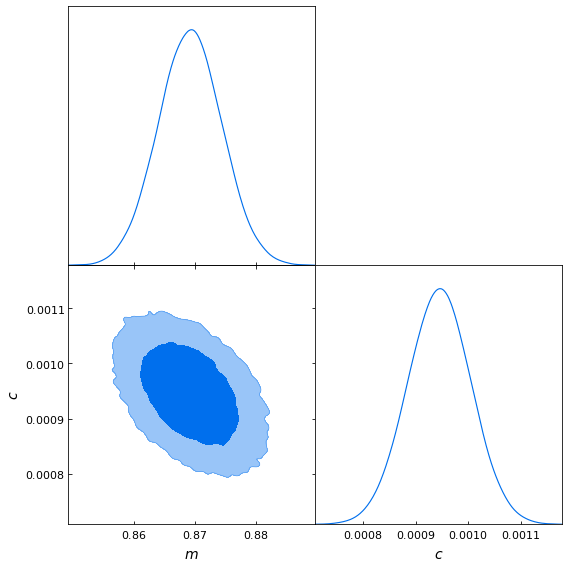

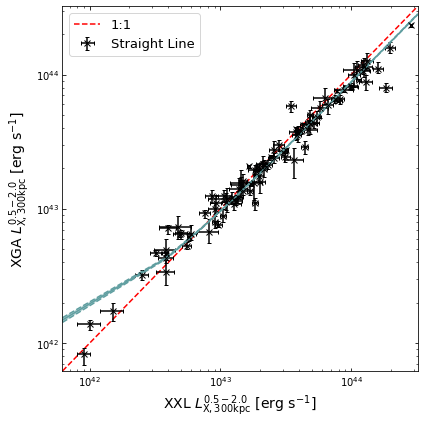

m=0.869 +0.005 -0.005 [1sig]
c=0.001 +0.0 -0.0 [1sig]


In [15]:
fit_comp(xxlgc100_lx52, xxl_lx, [[0, 100], [0, 5]], r"XXL $L^{\rm{0.5-2.0}}_{\rm{X, 300kpc}}$ [erg s$^{-1}$]", 
         r"XGA $L^{\rm{0.5-2.0}}_{\rm{X, 300kpc}}$ [erg s$^{-1}$]", Quantity(1e+45, 'erg/s'), num_steps=20000, 
         view_chains=True, linear=True, view_corner=True, xscale='log', yscale='log')